# HiBench Benchmarks

## Sort Application

In [1]:
from glob import glob
import sys
if not 'spark_log_stats' in sys.path:
    sys.path.append('spark_log_stats')
import pandas as pd
import numpy as np
# Show graph in this notebook instead of opening a window
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from sparklogstats import LogParser

# Make graphs more readable
matplotlib.rcParams.update({'font.size': 16,
                            'font.family': 'serif',
                            'lines.linewidth': 2})
pd.options.display.max_rows = 999
pd.options.display.precision = 2

In [2]:
# Read Spark log files
def parse_application(name):
    cols = ['application', 'workers', 'input', 'duration']
    values = {};
    for col in cols:
        values[col] = []
        
    parser = LogParser()
    for log in sorted(glob('data/hibench/{}/*'.format(name))):
        app = parser.parse_file(log)
        values['workers'].append(len(app.slaves))
        values['input'].append(sum(t.metrics.bytes_read for t in app.stages[0].tasks if not t.failed))
        values['duration'].append(app.duration)
        values['application'].append(app.name)

    return pd.DataFrame(values, columns=cols)

In [3]:
df = pd.concat([parse_application('sort'), parse_application('kmeans')])
df['input'] /= 1024**2  # megabytes
df['duration'] /= 1000  # seconds

In [4]:
dfs = df[df['application'] == 'ScalaSort'].drop('application', axis=1)
dfs.groupby(['input','workers']).agg([np.mean, np.std, np.size])

duration             
                     mean     std size
input    workers                      
262.80   1          31.78    1.72   10
         2          29.38    9.79   10
525.60   1          51.72    5.78   10
         2          36.14    4.07   10
         4          28.12    1.25   10
1051.18  1         106.80   45.17   10
         2          54.55    2.36   10
         4          71.97   31.20   10
         8          29.82    1.46   10
2102.38  2          93.43    2.30   10
         4          79.89   42.27   10
         8          43.75    1.65   10
3132.80  1         392.65  234.46   10
         2         134.82    3.14   10
         4          88.28    4.21   10
         8          62.75    3.77   10
         12         50.84    2.34   10
         16         47.48    3.92   10
31327.82 16        334.55   21.11   10
         32        280.41   15.84   10
         64        356.69  152.74   10
         123       263.50  229.83   10
         128       174.30   11.50   10

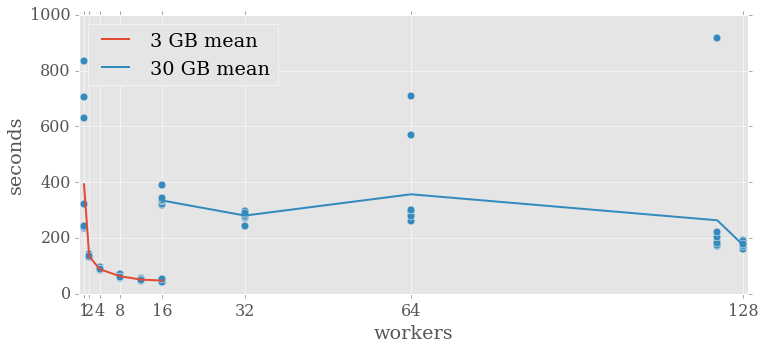

In [5]:
df_plot = dfs[['workers', 'duration']]

df_input = df_plot[(dfs['input'] > 3000) & (dfs['input'] < 4000)]
ax = df_input.plot(kind='scatter', x='workers', y='duration', s=60, legend=False, figsize=(12,5))
df_input.groupby('workers').mean().plot(ax=ax)

df_input = df_plot[dfs['input'] > 30000]
df_input.plot(kind='scatter', x='workers', y='duration', s=60, legend=False, ax=ax)
df_input.groupby('workers').mean().plot(ax=ax, xlim=(0, 129), ylim=(0, None))

ax.set_ylabel('seconds')
ax.set_xticks([2**i for i in range(0, 8)])
plt.legend(['3 GB mean', '30 GB mean'], loc='upper left')

plt.show()

## Kmeans Application

In [6]:
dfk = df[df['application'].str.startswith('DenseKMeans')].drop('application', axis=1)

# From input size, infer number of samples
b2s = {}
k_samples = 32
for mb in sorted(dfk['input'].unique()):
    b2s[mb] = k_samples
    k_samples *= 2
    
dfk['samples'] = dfk['input'].apply(lambda mb: b2s[mb])  # thousand samples
dfk.drop('input', axis=1, inplace=True)

dfk.groupby(['samples','workers']).agg([np.mean, np.std, np.size])

duration             
                    mean     std size
samples workers                      
32      1          18.97    1.16   10
        2          18.72    2.28   10
        3          18.45    2.47   10
        4          18.88    0.64   10
        5          19.72    0.88   10
        6          20.97    0.95   10
        7          21.90    2.05   10
        8          26.26    9.66   10
64      1          19.08    0.80   10
        2          18.60    0.56   10
        3          17.92    0.38   10
        4          19.13    0.64   10
        5          20.41    0.76   10
        6          21.32    0.90   10
        7          21.78    1.10   10
        8          22.56    1.06   10
128     1          20.51    0.74   10
        2          19.37    0.54   10
        3          18.60    0.55   10
        4          19.71    0.49   10
        5          21.00    0.48   10
        6          21.29    0.93   10
        7          22.50    0.85   10
        8          22.42    0.60   10
256     1          22.83    0.78   10
        2          21.02    1.01   10
        3          19.50    0.42   10
        4          20.57    0.52   10
        5          21.58    0.82   10
        6          22.76    0.60   10
        7          23.64    0.91   10
        8          24.39    0.83   10
512     1          28.33    1.86   11
        2          24.19    0.61   10
        3          21.51    0.45   10
        4          22.68    0.53   10
        5          23.69    0.85   10
        6          24.85    0.72   10
        7          25.54    1.14   10
        8          25.99    1.50   10
1024    1          36.55    1.22   10
        2          30.13    0.73   10
        3          24.90    0.45   10
        4          26.01    0.55   10
        5          27.45    0.85   10
        6          28.37    0.83   10
        7          28.60    0.81   10
        8          29.76    0.96   10
2048    1          52.56    1.60   10
        2          40.73    2.14   10
        3          30.98    0.66   10
        4          32.07    0.85   10
        5          33.35    0.80   10
        6          34.46    1.27   10
        7          34.50    0.90   10
        8          35.25    1.21   10
4096    1         144.61    2.55   10
        2          55.40    1.58   10
        3          44.18    1.17   10
        4          42.52    2.17   10
        5          38.88    0.85   10
        6          39.74    0.84   10
        7          40.50    0.71   10
        8          42.32    1.20   10
8192    2         870.80   32.39   10
        4         286.28   25.29   10
        8          61.45    2.09   10
        16         60.72   13.48   10
        32         52.55    3.84   10
16384   8        1422.34  347.03   10
        16        419.93   72.47   10
        32         74.69    2.26   10
        64         71.54    4.37   10
        128        76.36   14.36   10

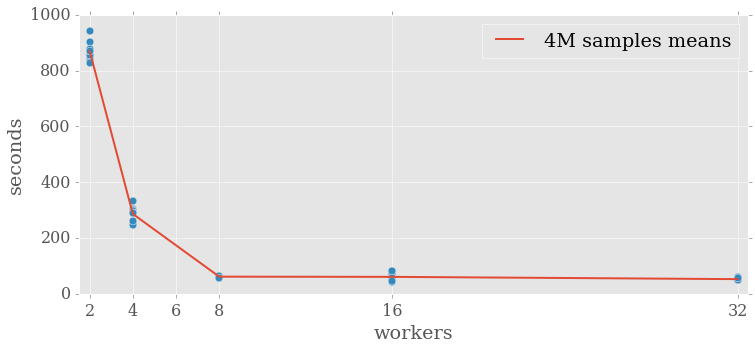

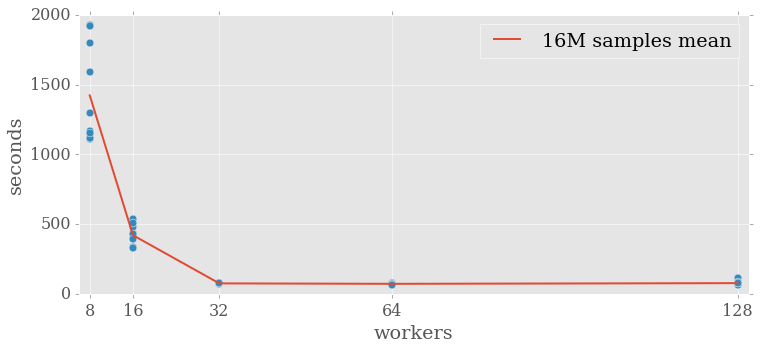

In [7]:
df_plot = dfk[['workers', 'duration']]

df_input = df_plot[dfk['samples'] == 8192]
ax = df_input.plot(kind='scatter', x='workers', y='duration', s=60, legend=False, figsize=(12,5))
df_input.groupby('workers').mean().plot(ax=ax, xlim=(1.5, 32.5), ylim=(0, None), xticks=(2, 4, 6, 8, 16, 32))
plt.legend(['4M samples means'])
ax.set_ylabel('seconds')

df_input = df_plot[dfk['samples'] == 16384]
ax = df_input.plot(kind='scatter', x='workers', y='duration', s=60, legend=False, figsize=(12,5))
df_input.groupby('workers').mean().plot(ax=ax, xlim=(6, 130), ylim=(0, 2000), xticks=[2**i for i in range(3, 8)])
plt.legend(['16M samples mean'])
ax.set_ylabel('seconds')

plt.show()